In [1]:
import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, 
                         date_rules, 
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output, 
                         record, 
                         schedule_function, 
                         get_open_orders, 
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from zipline.utils.math_utils import nanstd
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')


/tmp/ipykernel_68/3906283880.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/conda/lib/python3.10/site-packages/exchange_calendars/exchange_calendar.py:2347: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
# Settings
MONTH = 10
YEAR = 6 * MONTH
N_LONGS = 4
N_SHORTS = 0
VOL_SCREEN = 500
start = pd.Timestamp('2015-01-01')
end = pd.Timestamp('2023-02-01')
capital_base = 1e7

In [12]:
class AnnualizedVolatility(CustomFactor):
    """
    Volatility. The degree of variation of a series over time as measured by
    the standard deviation of daily returns.
    https://en.wikipedia.org/wiki/Volatility_(finance)

    **Default Inputs:** [Returns(window_length=2)]

    Parameters
    ----------
    annualization_factor : float, optional
        The number of time units per year. Defaults is 252, the number of NYSE
        trading days in a normal year.
    """

    inputs = [Returns(window_length=90)]
    params = {"annualization_factor": 180.0}
    window_length = 21

    def compute(self, today, assets, out, returns, annualization_factor):
        out[:] = nanstd(returns, axis=0) * (annualization_factor**0.5)

In [13]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = AnnualizedVolatility()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    assets = factor_data.index
    
    longs = assets[factor_data.longs]
    divest = context.portfolio.positions.keys() - longs
    log.info('{} | Longs: {:2.0f} | {:,.2f}'.format(get_datetime().date(),
                                                                     len(longs), 
                                                                     context.portfolio.portfolio_value))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS if N_LONGS else 0)
def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.month_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, 
                                                   min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, 
                                                          price_impact=0.01))

In [14]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='qa_datalake',
                         capital_base=capital_base)

[ 23:25:38.300459]: INFO: 2015-01-02 | Longs:  4 | 10,000,000.00
[ 23:25:38.343555]: INFO: 2015-02-02 | Longs:  4 | 10,053,689.48
[ 23:25:38.378122]: INFO: 2015-03-02 | Longs:  4 | 10,571,473.21
[ 23:25:38.419856]: INFO: 2015-04-01 | Longs:  4 | 10,520,297.77
[ 23:25:38.460408]: INFO: 2015-05-01 | Longs:  4 | 10,736,214.58
[ 23:25:38.497643]: INFO: 2015-06-01 | Longs:  4 | 10,798,058.21
[ 23:25:38.539767]: INFO: 2015-07-01 | Longs:  4 | 10,664,591.14
[ 23:25:38.592162]: INFO: 2015-08-03 | Longs:  4 | 10,949,674.16
[ 23:25:38.636823]: INFO: 2015-09-01 | Longs:  4 | 9,897,590.55
[ 23:25:38.677379]: INFO: 2015-10-01 | Longs:  4 | 10,184,314.30
[ 23:25:38.719683]: INFO: 2015-11-02 | Longs:  4 | 11,282,371.01
[ 23:25:38.756253]: INFO: 2015-12-01 | Longs:  4 | 11,400,088.25
[ 23:25:38.795968]: INFO: 2016-01-04 | Longs:  4 | 11,070,805.25
[ 23:25:38.841857]: INFO: 2016-02-01 | Longs:  4 | 10,962,028.83
[ 23:25:38.878842]: INFO: 2016-03-01 | Longs:  4 | 11,014,545.24
[ 23:25:38.913814]: INFO: 

In [15]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [16]:
with pd.HDFStore('backtests.h5') as store:
    store.put('backtest/test', backtest)
    store.put('returns/test', returns)
    store.put('positions/test', positions)
    store.put('transactions/test', transactions)

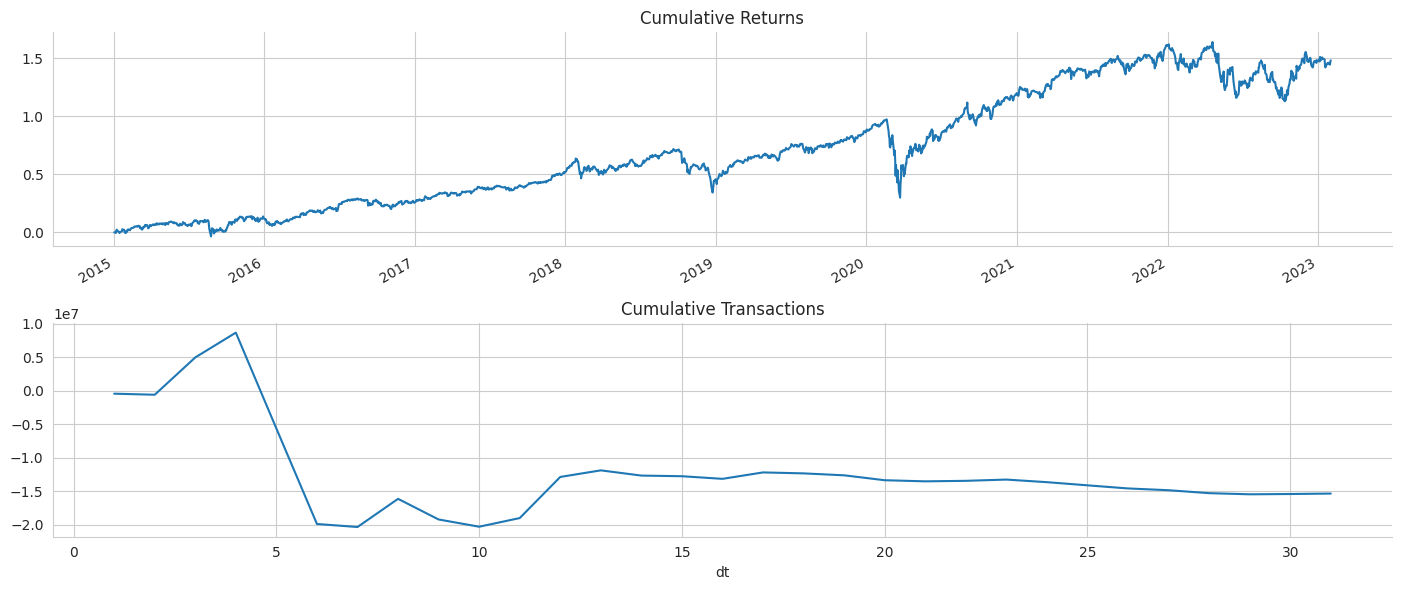

In [17]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
fig.tight_layout()
sns.despine();

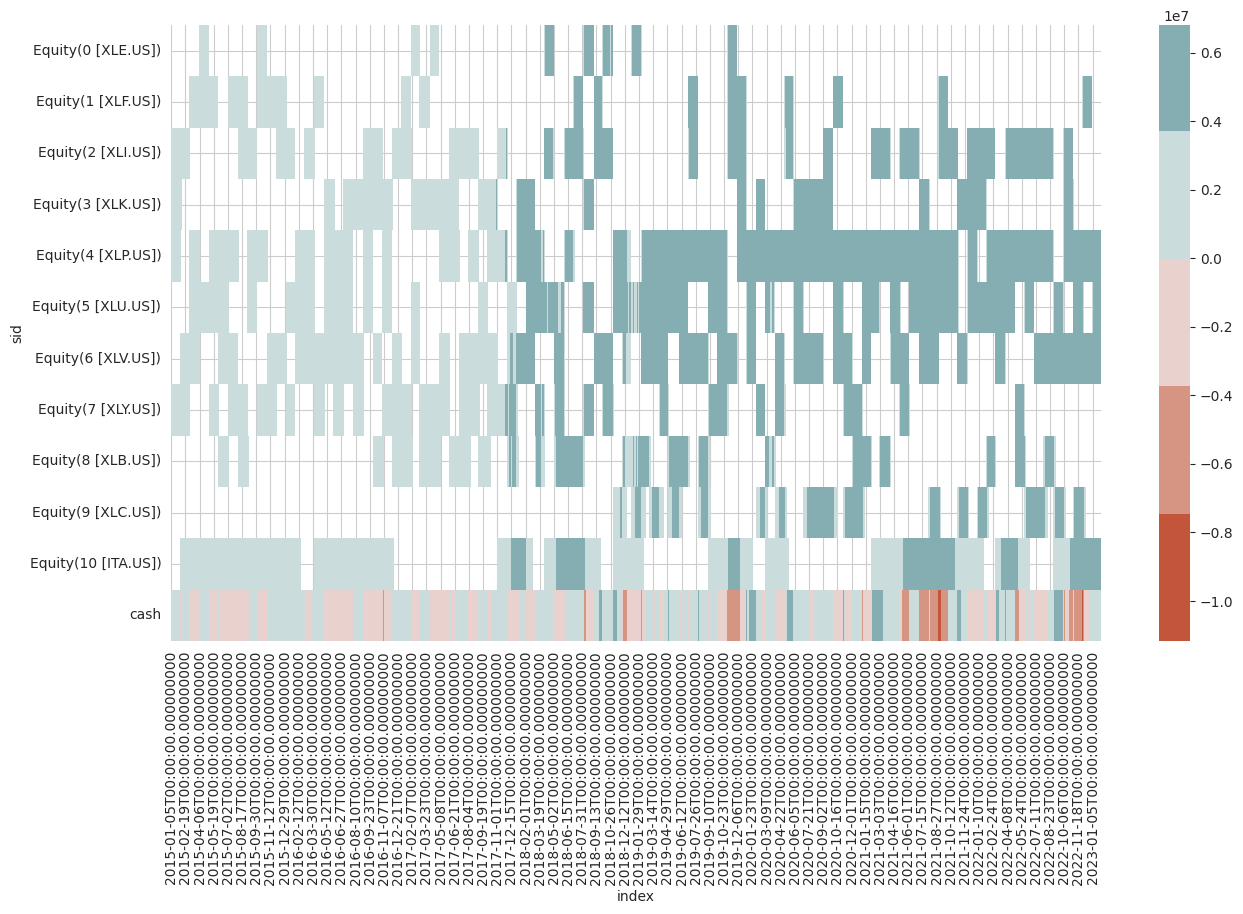

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(positions.replace(0, np.nan).dropna(how='all', axis=1).T, 
            cmap=sns.diverging_palette(h_neg=20, h_pos=200), ax=ax, center=0);

In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2488 entries, 2015-01-05 21:00:00+00:00 to 2023-01-09 21:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sid          2488 non-null   object             
 1   symbol       2488 non-null   object             
 2   price        2488 non-null   float64            
 3   order_id     2488 non-null   object             
 4   amount       2488 non-null   int64              
 5   commission   0 non-null      object             
 6   dt           2488 non-null   datetime64[ns, UTC]
 7   txn_dollars  2488 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 174.9+ KB


In [11]:
transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2015-01-05 21:00:00+00:00,Equity(2 [XLI.US]),Equity(2 [XLI.US]),55.190003,fa8b5a616d8f4e5d9f8a6d92a23b1fb2,37861,None,2015-01-05 21:00:00+00:00,-2.089549e+06
2015-01-05 21:00:00+00:00,Equity(3 [XLK.US]),Equity(3 [XLK.US]),40.640003,9e9fa26f5e0a4f03897b3715af8f8e7d,17986,None,2015-01-05 21:00:00+00:00,-7.309511e+05
2015-01-05 21:00:00+00:00,Equity(4 [XLP.US]),Equity(4 [XLP.US]),48.010003,560f54815fd54038aa27675eb31df975,20681,None,2015-01-05 21:00:00+00:00,-9.928949e+05
2015-01-05 21:00:00+00:00,Equity(7 [XLY.US]),Equity(7 [XLY.US]),70.260004,7de82d7a7133470aab86c00e8a2cd458,21457,None,2015-01-05 21:00:00+00:00,-1.507569e+06
2015-01-06 21:00:00+00:00,Equity(2 [XLI.US]),Equity(2 [XLI.US]),54.510000,fa8b5a616d8f4e5d9f8a6d92a23b1fb2,6378,None,2015-01-06 21:00:00+00:00,-3.476648e+05
...,...,...,...,...,...,...,...,...
2023-01-04 21:00:00+00:00,Equity(10 [ITA.US]),Equity(10 [ITA.US]),112.109993,7446b7abc9d14c75aa1d72df3f0f69a5,-1176,None,2023-01-04 21:00:00+00:00,1.318414e+05
2023-01-05 21:00:00+00:00,Equity(1 [XLF.US]),Equity(1 [XLF.US]),34.609999,1d5be2a254b548f48be5f33ef9bb3fb0,-65638,None,2023-01-05 21:00:00+00:00,2.271731e+06
2023-01-05 21:00:00+00:00,Equity(5 [XLU.US]),Equity(5 [XLU.US]),69.600004,f6ef7c9c510043c2adfe4628d3032082,24466,None,2023-01-05 21:00:00+00:00,-1.702834e+06
2023-01-06 21:00:00+00:00,Equity(5 [XLU.US]),Equity(5 [XLU.US]),71.000004,f6ef7c9c510043c2adfe4628d3032082,24525,None,2023-01-06 21:00:00+00:00,-1.741275e+06


In [ ]:
positions.index